This code trains a model using a fully connected feedforward neural network that performs conservative-to-primitive inversion based on the paper by Dieseldorst et al. The code consists of several steps:

- Importing the necessary modules and setting the random seed for reproducibility
- Checking if GPU is available and setting the device accordingly
- Defining the parameters for the neural network, such as input size, hidden sizes, output size, activation function, nonlinearity function, learning rate, batch size, number of epochs, number of training and test samples, and intervals for sampling primitive variables
- Generating the training and test datasets by uniformly sampling primitive variables and calculating corresponding conservative variables using equations from Dieseldorst et al.
- Converting the data to tensors and moving them to the device
- Defining the neural network class with three linear layers and an activation function and a nonlinearity function
- Creating an instance of the neural network and moving it to the
- Creating an instance of the neural network and moving it to the device
- Defining the loss function as mean squared error and the optimizer as Adam with the initial learning rate
- Initializing some variables to store and track the training progress and results, such as training and test losses and errors, best training loss, patience, wait, factor, and threshold
- Starting the training loop for the number of epochs
    - Shuffling the training data and splitting it into mini-batches
    - Initializing some variables to store and track the training loss and errors for each epoch
    - Looping over each mini-batch
        - Getting the input features and output labels for the current mini-batch
        - Forward pass: passing the input features through the network and getting the output predictions
        - Calculating the loss between the output predictions and output labels using the loss function
        - Backward pass: computing the gradients of the loss with respect to the network parameters using backpropagation
        - Updating the network parameters using the optimizer and the learning rate
        - Accumulating the training loss and errors for each mini-batch
    - Averaging the training loss and errors over all mini-batches and appending them to their respective lists
    - Evaluating the network on the test dataset by passing the test input features through the network and getting the test output predictions, calculating the test loss and errors, and appending them to their respective lists
    - Printing the epoch number, training loss, and test loss
    - Checking if the training loss has improved by at least the threshold percentage over the last patience epochs and adjusting the learning rate accordingly by multiplying it by a factor
    - Checking if the current training loss is better than the best training loss so far and saving the network parameters as "best_model.pth"
- Loading the network parameters from "best_model.pth"
- Plotting the training and test losses and errors over epochs and saving them as "loss.png", "l1_error.png", and "linf_error.png"
- Calculating the other primitive variables from the test output predictions using equations from Dieseldorst et al.
- Plotting the true vs predicted values of p, vx, eps, and rho for the test dataset and saving them as "p_true_vs_pred.png", "vx_true_vs_pred.png", "eps_true_vs_pred.png", and "rho_true_vs_pred.png"

In [1]:
# Importing the necessary modules
import torch # For tensor operations and neural network modules
import numpy as np # For numerical calculations
import matplotlib.pyplot as plt # For plotting results

# Setting the random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining the parameters for the neural network
input_size = 3 # The number of inputs: D, S_x, and tau
hidden_size1 = 600 # The number of neurons in the first hidden layer
hidden_size2 = 200 # The number of neurons in the second hidden layer
output_size = 1 # The number of outputs: p
activation = torch.sigmoid # The activation function for the hidden layers
nonlinearity = torch.relu # The nonlinearity applied to the output
learning_rate = 6e-4 # The initial learning rate for training
batch_size = 32 # The size of each mini-batch
num_epochs = 100 # The number of epochs to train the network
num_train = 80000 # The number of samples in the training dataset
num_test = 10000 # The number of samples in the test dataset

# Defining the intervals for sampling the primitive variables
rho_min = 0.0 # The lower bound of rho
rho_max = 10.1 # The upper bound of rho
eps_min = 0.0 # The lower bound of eps
eps_max = 2.02 # The upper bound of eps
vx_min = 0.0 # The lower bound of vx
vx_max = 0.721 # The upper bound of vx


In [2]:

# Generating the training dataset by uniformly sampling the primitive variables and calculating the corresponding conservative variables
rho_train = np.random.uniform(rho_min, rho_max, num_train) # Sampling rho from a uniform distribution
eps_train = np.random.uniform(eps_min, eps_max, num_train) # Sampling eps from a uniform distribution
vx_train = np.random.uniform(vx_min, vx_max, num_train) # Sampling vx from a uniform distribution

p_train = (rho_train * eps_train) / (1 - vx_train**2) # Calculating p from equation (A1) in Dieseldorst et al.
W_train = 1 / np.sqrt(1 - vx_train**2) # Calculating W from equation (2) in Dieseldorst et al.
h_train = 1 + eps_train + p_train / rho_train # Calculating h from equation (2) in Dieseldorst et al.

D_train = rho_train * W_train # Calculating D from equation (2) in Dieseldorst et al.
Sx_train = rho_train * h_train * W_train**2 * vx_train # Calculating S_x from equation (2) in Dieseldorst et al.
tau_train = rho_train * h_train * W_train**2 - p_train - D_train # Calculating tau from equation (2) in Dieseldorst et al.

X_train = np.stack([D_train, Sx_train, tau_train], axis=1) # Stacking the conservative variables as input features
y_train = p_train.reshape(-1, 1) # Reshaping p as output labels

# Converting the training data to tensors and moving them to the device
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)

# Generating the test dataset by uniformly sampling the primitive variables and calculating the corresponding conservative variables
rho_test = np.random.uniform(rho_min, rho_max, num_test) # Sampling rho from a uniform distribution
eps_test = np.random.uniform(eps_min, eps_max, num_test) # Sampling eps from a uniform distribution
vx_test = np.random.uniform(vx_min, vx_max, num_test) # Sampling vx from a uniform distribution

p_test = (rho_test * eps_test) / (1 - vx_test**2) # Calculating p from equation (A1) in Dieseldorst et al.
W_test = 1 / np.sqrt(1 - vx_test**2) # Calculating W from equation (2) in Dieseldorst et al.
h_test = 1 + eps_test + p_test / rho_test # Calculating h from equation (2) in Dieseldorst et al.

D_test = rho_test * W_test # Calculating D from equation (2) in Dieseldorst et al.
Sx_test = rho_test * h_test * W_test**2 * vx_test # Calculating S_x from equation (2) in Dieseldorst et al.
tau_test = rho_test * h_test * W_test**2 - p_test - D_test # Calculating tau from equation (2) in Dieseldorst et al.

X_test = np.stack([D_test, Sx_test, tau_test], axis=1) # Stacking the conservative variables as input features
y_test = p_test.reshape(-1, 1) # Reshaping p as output labels

# Converting the test data to tensors and moving them to the device
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)


In [3]:

# Defining the neural network class
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation, nonlinearity):
        super(NeuralNetwork, self).__init__() # Calling the parent class constructor
        self.input_size = input_size # Storing the input size as an attribute
        self.hidden_size1 = hidden_size1 # Storing the first hidden size as an attribute
        self.hidden_size2 = hidden_size2 # Storing the second hidden size as an attribute
        self.output_size = output_size # Storing the output size as an attribute
        self.activation = activation # Storing the activation function as an attribute
        self.nonlinearity = nonlinearity # Storing the nonlinearity function as an attribute
        
        # Defining the linear layers of the network
        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size1) # The first linear layer that maps the input to the first hidden layer
        self.linear2 = torch.nn.Linear(self.hidden_size1, self.hidden_size2) # The second linear layer that maps the first hidden layer to the second hidden layer
        self.linear3 = torch.nn.Linear(self.hidden_size2, self.output_size) # The third linear layer that maps the second hidden layer to the output
        
    def forward(self, x):
        # Defining the forward pass of the network
        x = self.linear1(x) # Passing the input through the first linear layer
        x = self.activation(x) # Applying the activation function to the output of the first linear layer
        x = self.linear2(x) # Passing the output of the first activation function through the second linear layer
        x = self.activation(x) # Applying the activation function to the output of the second linear layer
        x = self.linear3(x) # Passing the output of the second activation function through the third linear layer
        x = self.nonlinearity(x) # Applying the nonlinearity function to the output of the third linear layer
        return x # Returning the final output


In [5]:

# Creating an instance of the neural network and moving it to the device
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size, activation, nonlinearity).to(device)

# Defining the loss function as mean squared error
criterion = torch.nn.MSELoss()

# Defining the optimizer as Adam with the initial learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initializing some variables to store and track the training progress and results
train_loss_list = [] # A list to store the training loss for each epoch
test_loss_list = [] # A list to store the test loss for each epoch
train_l1_list = [] # A list to store the training L_1 error for each epoch
test_l1_list = [] # A list to store the test L_1 error for each epoch
train_linf_list = [] # A list to store the training L_infinity error for each epoch
test_linf_list = [] # A list to store the test L_infinity error for each epoch

best_train_loss = float('inf') # A variable to store the best training loss so far
patience = 10 # A variable to store the number of epochs to wait before adjusting the learning rate
wait = 0 # A variable to store the number of epochs since the last improvement in training loss
factor = 0.5 # A variable to store the factor by which to reduce the learning rate
threshold = 0.0005 # A variable to store the threshold for improvement in training loss

# Starting the training loop
for epoch in range(num_epochs):
    # Shuffling the training data and splitting it into mini-batches
    permutation = torch.randperm(num_train) # Generating a random permutation of indices
    X_train = X_train[permutation] # Shuffling the input features according to the permutation
    y_train = y_train[permutation] # Shuffling the output labels according to the permutation
    
    # Initializing some variables to store and track the training loss and errors for each epoch
    train_loss = 0.0 # A variable to store the training loss for each epoch
    train_l1 = 0.0 # A variable to store the training L_1 error for each epoch
    train_linf = 0.0 # A variable to store the training L_infinity error for each epoch
    
    # Looping over each mini-batch
    for i in range(0, num_train, batch_size):
        # Getting the input features and output labels for the current mini-batch
        X_batch = X_train[i:i+batch_size] # Slicing the input features according to the batch size
        y_batch = y_train[i:i+batch_size] # Slicing the output labels according to the batch size
        
        # Forward pass: passing the input features through the network and getting the output predictions
        y_pred = model(X_batch)
        
        # Calculating the loss between the output predictions and output labels using the loss function
        loss = criterion(y_pred, y_batch)
        
        # Backward pass: computing the gradients of the loss with respect to the network parameters using backpropagation
        optimizer.zero_grad() # Clearing any previous gradients
        loss.backward() # Computing the gradients
        
        # Updating the network parameters using the optimizer and the learning rate
        optimizer.step() # Taking a step in the direction of the gradients
        
        # Accumulating the training loss and errors for each mini-batch
        train_loss += loss.item() * batch_size # Multiplying by batch size to get the total loss for each mini-batch
        train_l1 += torch.sum(torch.abs(y_pred - y_batch)).item() # Summing up the absolute errors for each mini-batch
        train_linf += torch.max(torch.abs(y_pred - y_batch)).item() # Taking the maximum absolute error for each mini-batch
    
    # Averaging the training loss and errors over all mini-batches and appending them to their respective lists
    train_loss /= num_train # Dividing by num_train to get the average loss per sample
    train_l1 /= num_train # Dividing by num_train to get the average L_1 error per sample
    train_loss_list.append(train_loss) # Appending the average training loss to its list
    train_l1_list.append(train_l1) # Appending the average training L_1 error to its list
    train_linf_list.append(train_linf) # Appending the maximum training L_infinity error to its list
        
    # Evaluating the network on the test dataset
    with torch.no_grad(): # Disabling gradient computation to save memory and speed up evaluation
        # Forward pass: passing the test input features through the network and getting the test output predictions
        y_test_pred = model(X_test)
        
        # Calculating the loss between the test output predictions and test output labels using the loss function
        test_loss = criterion(y_test_pred, y_test).item()
        
        # Calculating the test L_1 and L_infinity errors
        test_l1 = torch.sum(torch.abs(y_test_pred - y_test)).item() / num_test # Dividing by num_test to get the average L_1 error per sample
        test_linf = torch.max(torch.abs(y_test_pred - y_test)).item() # Taking the maximum absolute error
        
        # Appending the test loss and errors to their respective lists
        test_loss_list.append(test_loss)
        test_l1_list.append(test_l1)
        test_linf_list.append(test_linf)
    
    # Printing the epoch number, training loss, and test loss
    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    # Checking if the training loss has improved by at least the threshold percentage over the last patience epochs
    if epoch >= patience: # Only checking after patience epochs have been completed
        prev_loss = train_loss_list[epoch-patience] # Getting the training loss from patience epochs ago
        curr_loss = train_loss_list[epoch] # Getting the current training loss
        improvement = (prev_loss - curr_loss) / prev_loss # Calculating the percentage improvement
        if improvement < threshold: # If the improvement is less than the threshold
            wait += 1 # Incrementing the wait counter
            if wait == patience: # If the wait counter reaches the patience limit
                learning_rate *= factor # Reducing the learning rate by the factor
                print(f"Reducing learning rate to {learning_rate:.4f}") # Printing the new learning rate
                for param_group in optimizer.param_groups: # Looping over each parameter group in the optimizer
                    param_group['lr'] = learning_rate # Setting the learning rate for each parameter group
                wait = 0 # Resetting the wait counter
        else: # If the improvement is greater than or equal to the threshold
            wait = 0 # Resetting the wait counter
    
    # Checking if the current training loss is better than the best training loss so far
    if train_loss < best_train_loss: # If the current training loss is better than the best training loss so far
        best_train_loss = train_loss # Updating the best training loss so far
        torch.save(model.state_dict(), "best_model.pth") # Saving the network parameters as "best_model.pth"
   

Epoch 1, Training Loss: 2.7004, Test Loss: 0.0832
Epoch 2, Training Loss: 0.0311, Test Loss: 0.0238
Epoch 3, Training Loss: 0.0124, Test Loss: 0.0139
Epoch 4, Training Loss: 0.0096, Test Loss: 0.0182
Epoch 5, Training Loss: 0.0085, Test Loss: 0.0012
Epoch 6, Training Loss: 0.0107, Test Loss: 0.0111
Epoch 7, Training Loss: 0.0123, Test Loss: 0.0030
Epoch 8, Training Loss: 0.0074, Test Loss: 0.0009
Epoch 9, Training Loss: 0.0095, Test Loss: 0.0064
Epoch 10, Training Loss: 0.0093, Test Loss: 0.0009
Epoch 11, Training Loss: 0.0088, Test Loss: 0.0017
Epoch 12, Training Loss: 0.0069, Test Loss: 0.0006
Epoch 13, Training Loss: 0.0083, Test Loss: 0.0020
Epoch 14, Training Loss: 0.0070, Test Loss: 0.0013
Epoch 15, Training Loss: 0.0059, Test Loss: 0.0005
Epoch 16, Training Loss: 0.0068, Test Loss: 0.0046
Epoch 17, Training Loss: 0.0070, Test Loss: 0.0008
Epoch 18, Training Loss: 0.0063, Test Loss: 0.0003
Epoch 19, Training Loss: 0.0071, Test Loss: 0.0005
Epoch 20, Training Loss: 0.0052, Test Lo

<All keys matched successfully>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss vs Epoch')

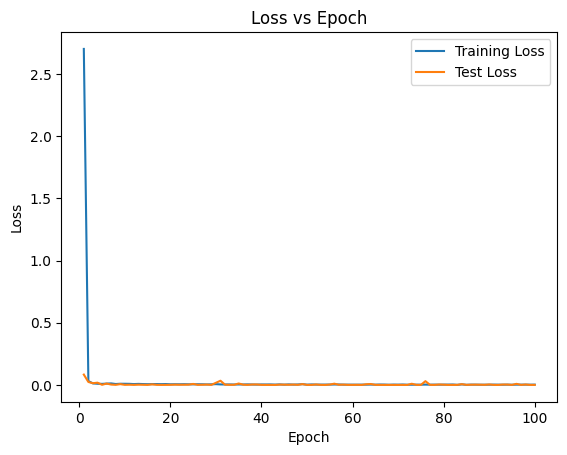

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'L_1 Error')

Text(0.5, 1.0, 'L_1 Error vs Epoch')

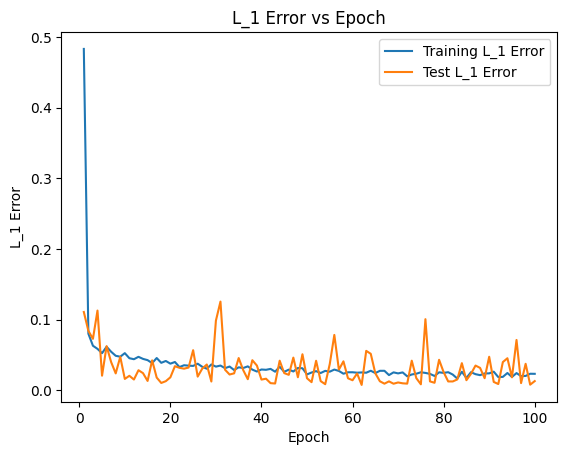

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'L_infinity Error')

Text(0.5, 1.0, 'L_infinity Error vs Epoch')

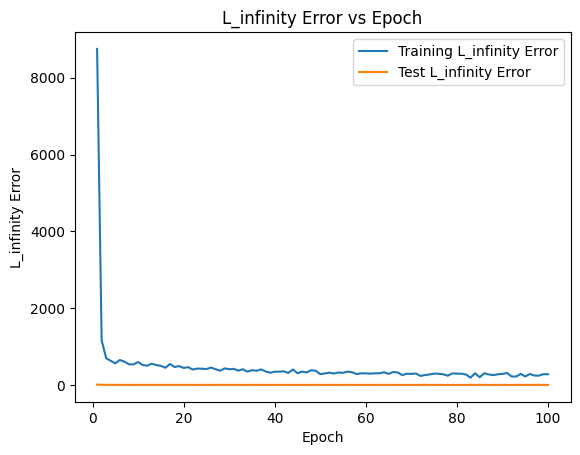

Text(0.5, 0, 'True p')

Text(0, 0.5, 'Predicted p')

Text(0.5, 1.0, 'True vs Predicted p for Test Dataset')

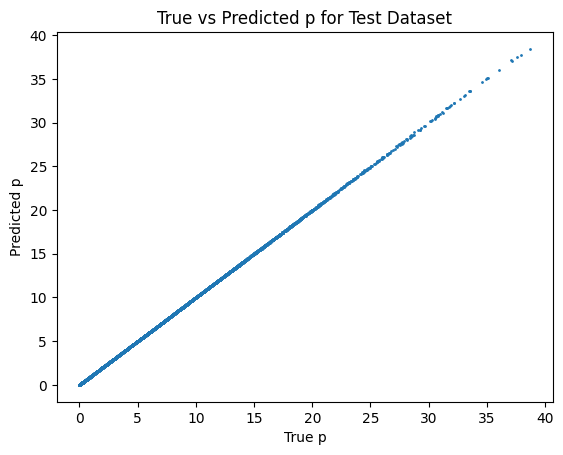

Text(0.5, 0, 'True vx')

Text(0, 0.5, 'Predicted vx')

Text(0.5, 1.0, 'True vs Predicted vx for Test Dataset')

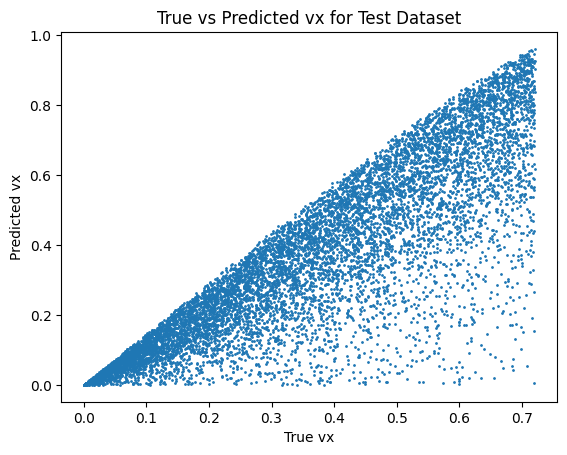

Text(0.5, 0, 'True eps')

Text(0, 0.5, 'Predicted eps')

Text(0.5, 1.0, 'True vs Predicted eps for Test Dataset')

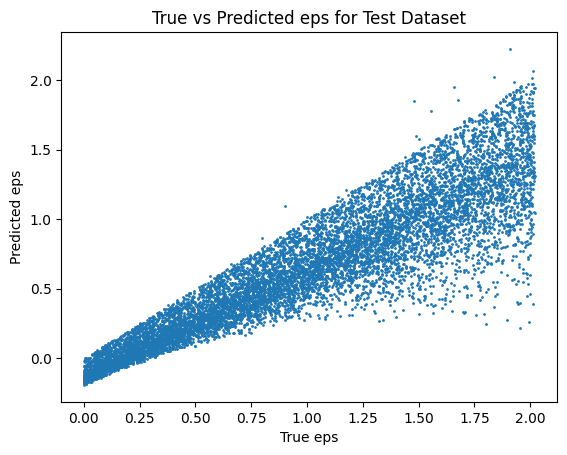

Text(0.5, 0, 'True rho')

Text(0, 0.5, 'Predicted rho')

Text(0.5, 1.0, 'True vs Predicted rho for Test Dataset')

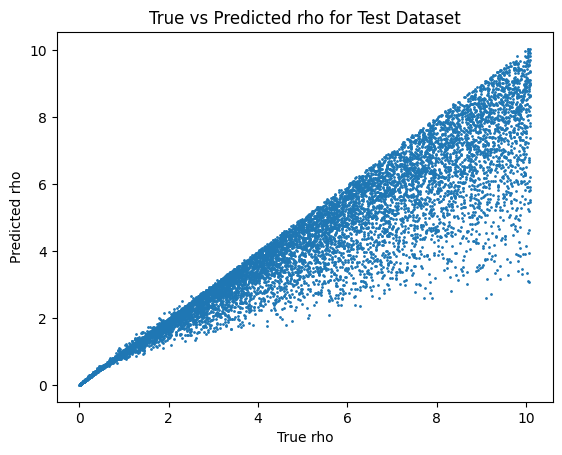

In [18]:
 
# Loading the network parameters from "best_model.pth"
model.load_state_dict(torch.load("best_model.pth"))

# Plotting the training and test losses over epochs
plt.plot(range(1, num_epochs+1), train_loss_list, label="Training Loss")
plt.plot(range(1, num_epochs+1), test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.savefig("loss.png") # Saving the plot as "loss.png"
plt.show() # Showing the plot

# Plotting the training and test L_1 errors over epochs
plt.plot(range(1, num_epochs+1), train_l1_list, label="Training L_1 Error")
plt.plot(range(1, num_epochs+1), test_l1_list, label="Test L_1 Error")
plt.xlabel("Epoch")
plt.ylabel("L_1 Error")
plt.legend()
plt.title("L_1 Error vs Epoch")
plt.savefig("l1_error.png") # Saving the plot as "l1_error.png"
plt.show() # Showing the plot

# Plotting the training and test L_infinity errors over epochs
plt.plot(range(1, num_epochs+1), train_linf_list, label="Training L_infinity Error")
plt.plot(range(1, num_epochs+1), test_linf_list, label="Test L_infinity Error")
plt.xlabel("Epoch")
plt.ylabel("L_infinity Error")
plt.legend()
plt.title("L_infinity Error vs Epoch")
plt.savefig("linf_error.png") # Saving the plot as "linf_error.png"
plt.show() # Showing the plot

# Calculating the other primitive variables from the test output predictions using equations (A2), (A3), (A4), and (A5) in Dieseldorst et al.
#vx_test_pred = torch.from_numpy(Sx_test).to(device) / (torch.from_numpy(tau_test).to(device) + torch.from_numpy(D_test).to(device) + y_test_pred) # Calculating vx from equation (A2)
#W_test_pred = 1 / torch.sqrt(1 - vx_test_pred**2) # Calculating W from equation (A3)
#eps_test_pred = (tau_test + D_test * (1 - W_test_pred) + y_test_pred * (1 - W_test_pred**2)) / (D_test * W_test_pred) # Calculating eps from equation (A4)
#rho_test_pred = D_test / W_test_pred # Calculating rho from equation (A5)

vx_test_pred = torch.from_numpy(Sx_test).to(device) / (torch.from_numpy(tau_test).to(device) + torch.from_numpy(D_test).to(device) + y_test_pred) # Calculating vx from equation (A2)
W_test_pred = 1 / torch.sqrt(1 - vx_test_pred) # Calculating W from equation (A3)
eps_test_pred = (torch.from_numpy(tau_test).to(device) + torch.from_numpy(D_test).to(device) * (1 - W_test_pred) + y_test_pred * (1 - W_test_pred)) / (torch.from_numpy(D_test).to(device) * W_test_pred) # Calculating eps from equation (A4)
rho_test_pred = torch.from_numpy(D_test).to(device) / W_test_pred # Calculating rho from equation (A5)

# Plotting the true vs predicted values of p for the test dataset
plt.scatter(y_test.cpu().numpy(), y_test_pred.cpu().numpy(), s=1)
plt.xlabel("True p")
plt.ylabel("Predicted p")
plt.title("True vs Predicted p for Test Dataset")
plt.savefig("p_true_vs_pred.png") # Saving the plot as "p_true_vs_pred.png"
plt.show() # Showing the plot

# Plotting the true vs predicted values of vx for the test dataset
#plt.scatter(vx_test, vx_test_pred.cpu().numpy(), s=1)
#plt.scatter(vx_test, vx_test_pred.cpu().numpy()[0], s=1)
plt.xlabel("True vx")
plt.ylabel("Predicted vx")
plt.title("True vs Predicted vx for Test Dataset")
plt.savefig("vx_true_vs_pred.png") # Saving the plot as "vx_true_vs_pred.png"
plt.show() # Showing the plot

# Plotting the true vs predicted values of eps for the test dataset
#plt.scatter(eps_test, eps_test_pred.cpu().numpy(), s=1)
plt.scatter(eps_test, eps_test_pred.cpu().numpy()[0], s=1)
plt.xlabel("True eps")
plt.ylabel("Predicted eps")
plt.title("True vs Predicted eps for Test Dataset")
plt.savefig("eps_true_vs_pred.png") # Saving the plot as "eps_true_vs_pred.png"
plt.show() # Showing the plot

# Plotting the true vs predicted values of rho for the test dataset
#plt.scatter(rho_test, rho_test_pred.cpu().numpy(), s=1)
plt.scatter(rho_test, rho_test_pred.cpu().numpy()[0], s=1)
plt.xlabel("True rho")
plt.ylabel("Predicted rho")
plt.title("True vs Predicted rho for Test Dataset")
plt.savefig("rho_true_vs_pred.png") # Saving the plot as "rho_true_vs_pred.png"
plt.show() # Showing the plot